In [1]:
from src.model_save_load import load_mesh
from pathlib import Path

data_dir = Path("./data/hammer")
initial_mesh_file = data_dir / "initial_mesh.ply"
mesh_o3d, mesh_trimesh, info = load_mesh(initial_mesh_file, vis=False)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from src import scene_process
scene_dir = data_dir/"scenes"
scene_process.process_scenes(scene_dir, "a hammer")



UnboundLocalError: cannot access local variable 'x_min' where it is not associated with a value

In [10]:
import numpy as np
scene_dict = np.load(data_dir/"scenes/hold_hammer_002157.npz")
scene_image = scene_dict["image"]

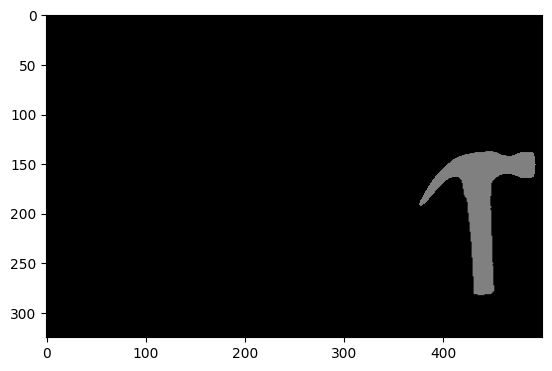

In [11]:
import matplotlib.pyplot as plt
hand_bbox = scene_dict["hand_bbox"]
plt.imshow(scene_image)

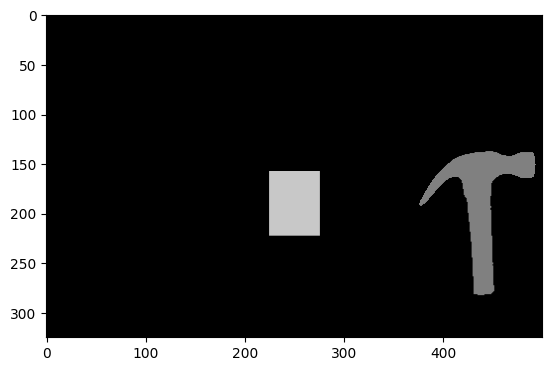

In [12]:
from src import bbox_utils
image = bbox_utils.add_bbox_to_image(scene_image, np.array([225, 158, 275, 222]))
plt.imshow(image)

In [5]:
import numpy as np
import point_cloud_utils as pcu
import open3d as o3d

# Step 1: Load the PLY file (vertices, faces, and colors)
mesh = o3d.io.read_triangle_mesh("./data/hammer/initial_mesh.ply")
vertices = np.asarray(mesh.vertices)      # (N, 3) 3D coordinates
faces = np.asarray(mesh.triangles)        # (M, 3) Triangle indices
colors = np.asarray(mesh.vertex_colors)   # (N, 3) RGB colors in range [0,1]

# Step 2: Sample points from the mesh using Poisson Disk Sampling
face_ids, bary_coords = pcu.sample_mesh_poisson_disk(vertices, faces, num_samples=10000)

# Step 3: Convert barycentric coordinates to 3D points
sampled_points = np.zeros((bary_coords.shape[0], 3))  # (num_samples, 3)
for i, (face_id, bary_coord) in enumerate(zip(face_ids, bary_coords)):
    # Get the 3 vertices of the face
    v0, v1, v2 = vertices[faces[face_id]]
    # Compute the 3D point from barycentric coordinates
    sampled_points[i] = v0 * bary_coord[0] + v1 * bary_coord[1] + v2 * bary_coord[2]

# Step 4: Interpolate colors for the sampled points using nearest neighbor search
# Find the nearest vertex for each sampled point and assign its color
distances, nearest_indices = pcu.k_nearest_neighbors(sampled_points, vertices, k=1)

# Flatten the indices array to match the shape of sampled points
nearest_indices = nearest_indices.flatten()
sampled_colors = colors[nearest_indices]

# Step 5: Save the new point cloud with colors
sampled_pcd = o3d.geometry.PointCloud()
sampled_pcd.points = o3d.utility.Vector3dVector(sampled_points)
sampled_pcd.colors = o3d.utility.Vector3dVector(sampled_colors)  # Assign interpolated colors

# Save as PLY
o3d.io.write_point_cloud("sampled_point_cloud_with_colors.ply", sampled_pcd)

# Step 6: Visualize the sampled point cloud
o3d.visualization.draw_geometries([sampled_pcd])